<a href="https://colab.research.google.com/github/kulkarohan/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [5]:
2 + 2

4

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

### Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
import scipy.stats as st 

%matplotlib inline

### Deterministic Nonlinear Function Underlying Our Generative Model

In [0]:
def f(x):
  return np.exp(3*x)

In [0]:
x_tr = np.linspace(0.,2,200)
y_tr = f(x_tr)

In [0]:
x = np.array([0,.1,.2,.5,.8,.9,1])
y = f(x) + 2*np.random.randn(len(x))

Text(0.5, 1.0, 'Generative model')

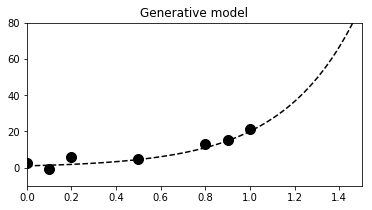

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(x_tr, y_tr, '--k')
ax.plot(x,y,'ok',ms=10)
ax.set_xlim(0,1.5)
ax.set_ylim(-10,80)
ax.set_title('Generative model')
# Dotted curve in image represents the generative model

### Linear Model


In [0]:
# Create model
lr = lm.LinearRegression()
# Train model on our training dataset
lr.fit(x[:, np.newaxis], y)
# Predict points with our trained model
y_lr = lr.predict(x_tr[:, np.newaxis])

Text(0.5, 1.0, 'Linear Regression')

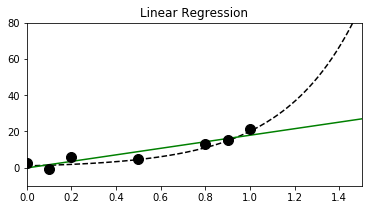

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(x_tr, y_tr, '--k')
ax.plot(x_tr, y_lr, 'g')
ax.plot(x,y,'ok', ms=10)
ax.set_xlim(0,1.5)
ax.set_ylim(-10, 80)
ax.set_title("Linear Regression")
# Linear model does not fit well

### Try A Polynomial Function

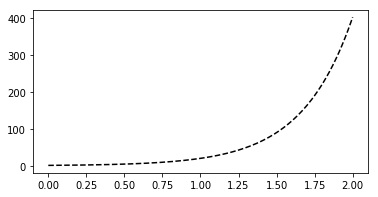

In [14]:
lrp = lm.LinearRegression()
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(x_tr, y_tr, '--k');

In [15]:
for deg, s in zip([2,5], ['-', '.']):
  lrp.fit(np.vander(x, deg+1), y)
  y_lrp = lrp.predict(np.vander(x_tr, deg+1))
  ax.plot(x_tr, y_lrp, s, label=f'degree {deg}')
  ax.legend(loc=2)
  ax.set_xlim(0,1.5)
  ax.set_ylim(-10,80)
  
  # Print the model's coefficients
  print(f'Coefficients, degree {deg}:\n\t',' '.join(f'{c:.2f}' for c in lrp.coef_))
  ax.plot(x,y,'ok',ms=10)
  ax.set_title('Linear regression')

Coefficients, degree 2:
	 23.46 -5.42 0.00
Coefficients, degree 5:
	 -787.83 1967.85 -1652.82 536.16 -44.29 0.00


Coefficients, degree 2: 11.66 5.81 0.00
Coefficients, degree 5: 3.85 3.87 3.79 3.68 3.77 0.00


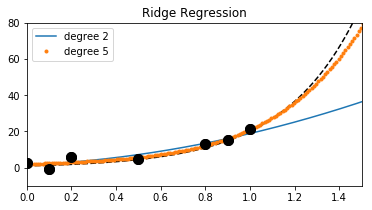

In [16]:
ridge = lm.RidgeCV()

fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(x_tr, y_tr, '--k')

for deg, s in zip([2,5], ['-','.']):
  ridge.fit(np.vander(x, deg+1), y)
  y_ridge = ridge.predict(np.vander(x_tr, deg+1))
  ax.plot(x_tr, y_ridge, s, label='degree ' + str(deg))
  ax.legend(loc=2)
  ax.set_xlim(0,1.5)
  ax.set_ylim(-10,80)
  
  # Print the model's coefficients
  print(f'Coefficients, degree {deg}:', ' '.join(f'{c:.2f}' for c in ridge.coef_))
  
  ax.plot(x,y,'ok',ms=10)
  ax.set_title('Ridge Regression')

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1) First, I created a function that assigns values to self-created (training) data. Then I implemented linear models to help pattern the self-created data and predict values for new, future (testing) data points as accurate as possible. I felt this tutorial was a good introduction to linear regression, curve fitting, scikit-learn, and various machine learning concepts.

2) Grasping the terminology used across the different libraries and how they work together was probably the most challenging/time-consuming.

3) The most interesting thing I learned was Ridge Regression. Introducing a small amount of bias when modeling training data could potentially reduce the amount of variance when aggregating testing data.

4) With more time I would read additional documentation and go deeper into various data science libraries.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.